In [55]:
import numpy as np
import sys
# import sklearn.model_selection as skl
# from sklearn.model_selection import train_test_split
import pickle

from keras.applications.resnet import decode_predictions

import matplotlib
import matplotlib.pyplot as plt
import time
import PIL

import os

from annoy import AnnoyIndex

# plt.rcParams["figure.figsize"]=1,1
# plt.rcParams["figure.height"]=2

In [56]:
# https://wiki.python.org/moin/UsingPickle

# Source directory:
src = './encodings/pretrained_resnet/'

chunk_1 = pickle.load(open(src + "imagenet_val_2048_encoding_" + str(1) + ".p", "rb") ) 
chunk_2 = pickle.load(open(src + "imagenet_val_2048_encoding_" + str(2) + ".p", "rb") ) 
chunk_3 = pickle.load(open(src + "imagenet_val_2048_encoding_" + str(3) + ".p", "rb") ) 
chunk_4 = pickle.load(open(src + "imagenet_val_2048_encoding_" + str(4) + ".p", "rb") ) 
chunk_5 = pickle.load(open(src + "imagenet_val_2048_encoding_" + str(5) + ".p", "rb") ) 

# encodings = np.concatenate([chunk_1])#, chunk_2, chunk_3, chunk_4, chunk_5], axis = 0)
encodings_1000 = np.concatenate([chunk_1[0], chunk_2[0], chunk_3[0], chunk_4[0], chunk_5[0]], axis = 0)
encodings_2048 = np.concatenate([chunk_1[1], chunk_2[1], chunk_3[1], chunk_4[1], chunk_5[1]], axis = 0)

In [11]:
# Use Annoy:
# NOTE: We leverage encoding order here.

# Build 2048 encoding database:
t = AnnoyIndex(2048, 'euclidean')
t.set_seed(13)

for idx, item in enumerate(encodings_2048):
    t.add_item(idx, item)
    
# t.get_nns_by_item(0, 100)
t.build(1000)
t.save('imagenet_val_encodings_2048.ann')

# Build 1000 encoding database:
t = AnnoyIndex(1000, 'euclidean')
t.set_seed(13)

for idx, item in enumerate(encodings_1000):
    t.add_item(idx, item)
    
# t.get_nns_by_item(0, 100)
t.build(1000)
t.save('imagenet_val_encodings_1000.ann')

KeyboardInterrupt: 

In [4]:
ann_2048 = AnnoyIndex(2048, 'euclidean')
ann_2048.load('imagenet_val_encodings_2048.ann')

ann_1000 = AnnoyIndex(1000, 'euclidean')
ann_1000.load('imagenet_val_encodings_1000.ann')


True

In [5]:
# start_time = time.time()

# u.get_nns_by_item(0, 1000)

# end_time = time.time()

# print(end_time - start_time)

In [57]:
# Generate corresponding filepaths:

# Generate target directories:
cwd = os.getcwd()
cwd += '/ImageNet/organized_validation_resnet/'

# print(cwd)

files_all = []

for i in range(1,1001):
    files = os.listdir(cwd + str(i))  # Get all the files in that directory
#     print(files)

    files_all += [str(i) + '/' + x for x in files]

print(len(files_all))

50000


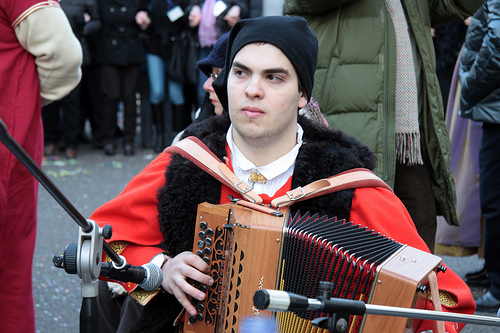

402


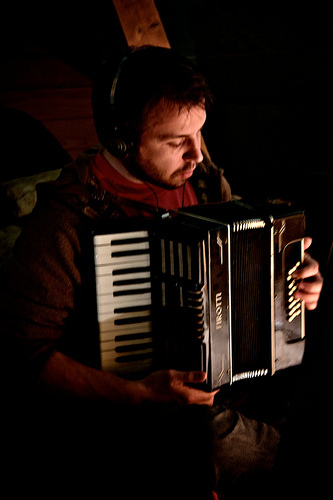

402


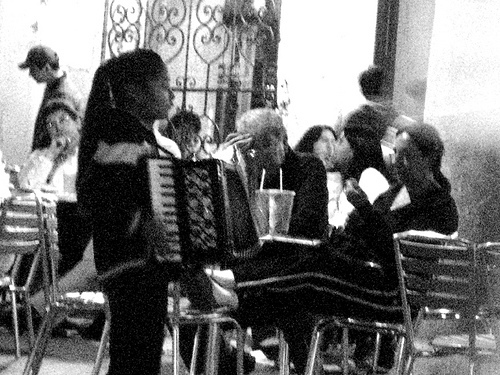

402


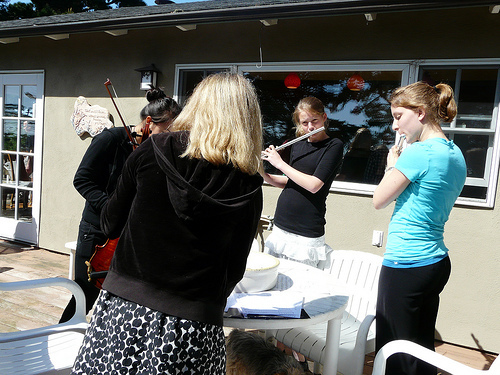

559


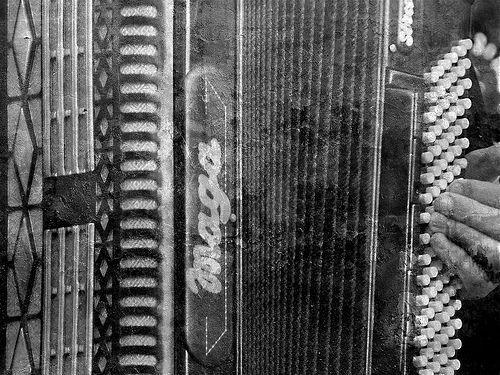

402


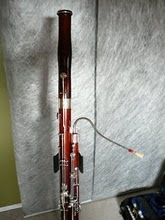

433


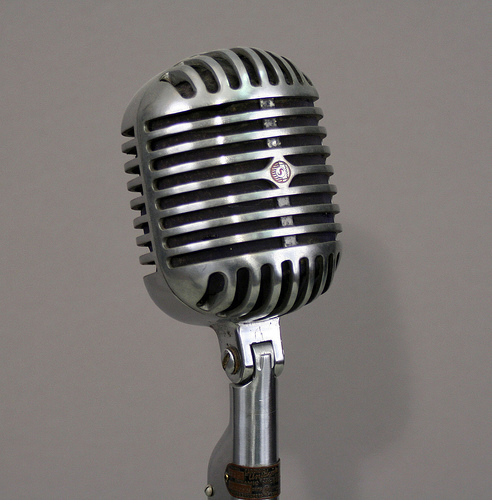

651


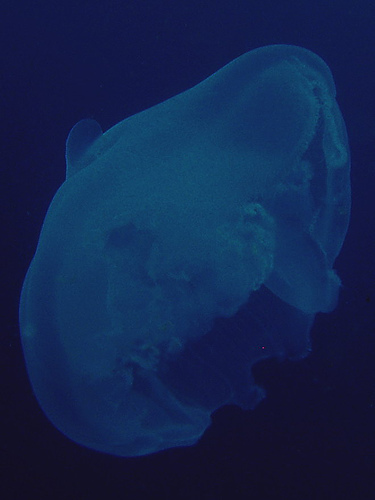

108


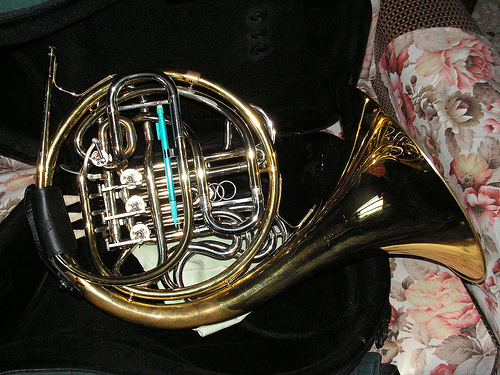

567


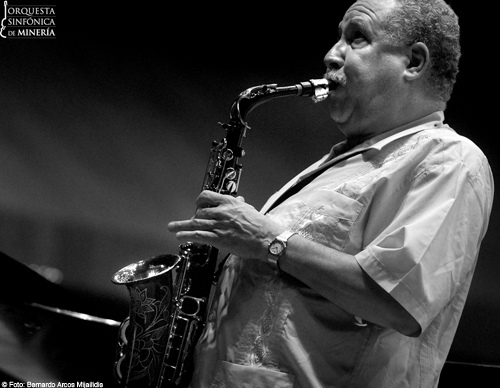

777


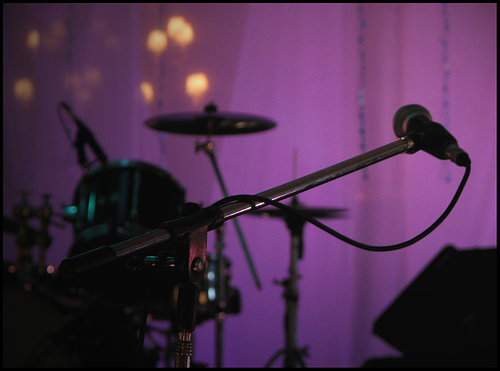

651


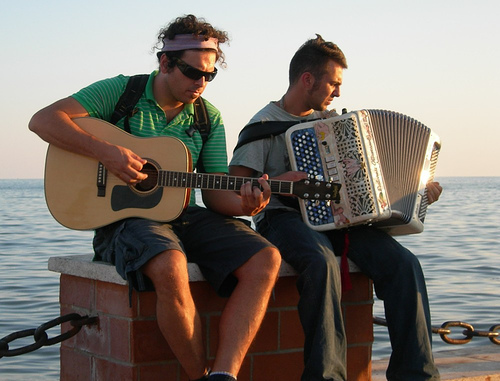

402


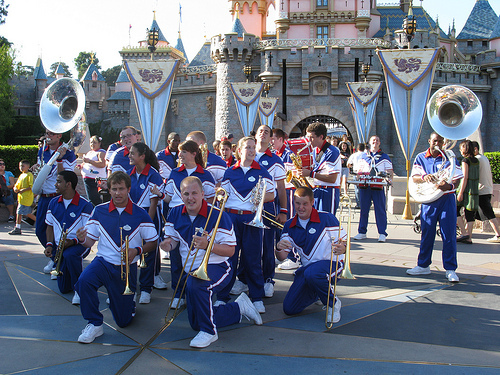

876


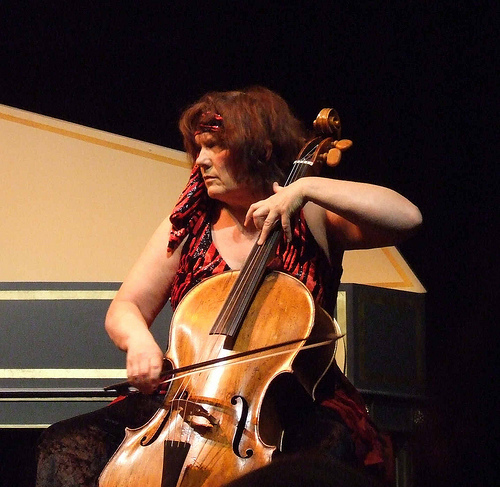

487


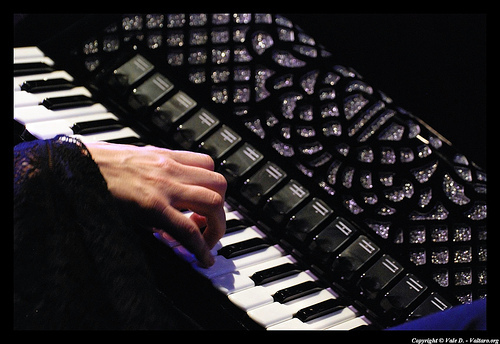

402


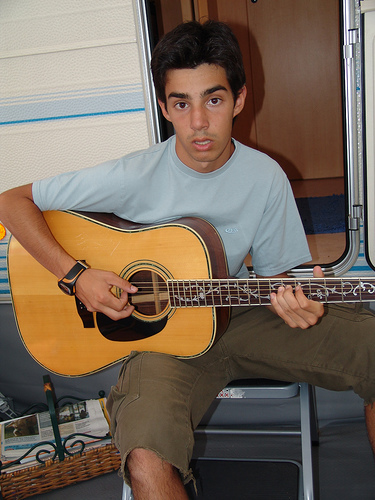

403


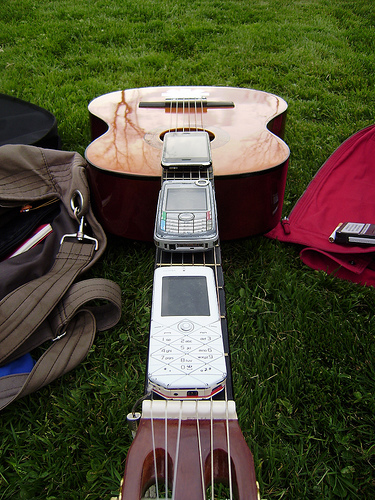

403


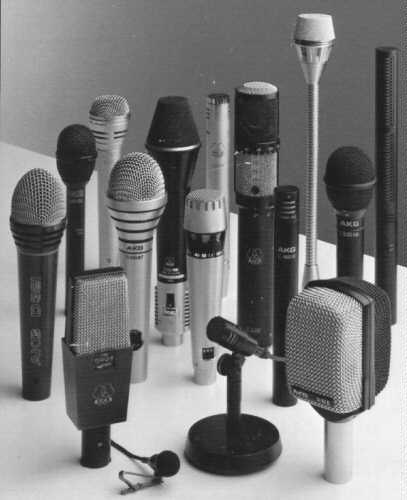

651


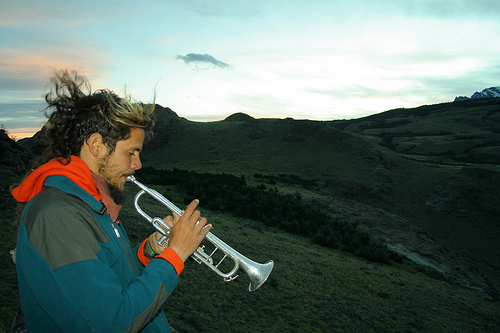

514


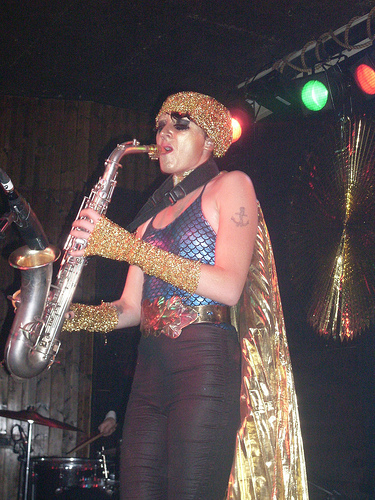

777


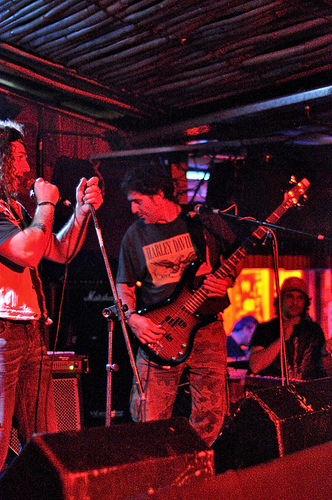

547


(3.316068172454834, 0.6, 0.3, 0.3333333333333333, 0.25)

In [61]:
# Use Brute Force:
def brute_force(query_index, num_nearest_n, encodings):
    start_time = time.time()

    first = encodings[query_index, :]
    dist_from_first = []


#     for idx, item in enumerate(encodings):
#         dist_from_first.append((np.linalg.norm((first)/np.linalg.norm(first)-(item)/np.linalg.norm(item)), idx))
#         dist_from_first.append((np.linalg.norm((first) - (item)), idx))#, item))
    
#     print(first.shape)
#     print(encodings.shape)
    
#     print(np.linalg.norm(first - encodings, axis = 0).shape)
#     print(np.linalg.norm((first - encodings), axis = 1).shape)


    dist_from_first = np.linalg.norm((first - encodings), axis = 1)
    dist_from_first_ranking = np.argsort(dist_from_first)
    
    #     print(dist_from_first_ranking)


    
    
    
#     print(dist_from_first[0:10])
    
    
#     dist_from_first.sort()

    end_time = time.time()

#     print('Query Time:')
#     print(end_time - start_time)

    
    query_img = PIL.Image.open(cwd + files_all[query_index])
    display(query_img)

    slash_index = files_all[query_index].find('/')
#     print(files_all[query_index][:slash_index])
    query_class = files_all[query_index][:slash_index]
    
#     pred = encodings[query_index].reshape(1, 1000)
#     decoded = decode_predictions(
#             pred, top=3
#             )
#     print(decoded)

    print(query_class)
    
    result_classes = []
    
    for i in range(1, num_nearest_n + 1):
        result_index = dist_from_first_ranking[i]
#         print(result_index)
        
#         pred = encodings[result_index].reshape(1, 1000)
#         decoded = decode_predictions(
#                 pred, top=3
#                 )
#         print(decoded)
        
        result_img = PIL.Image.open(cwd + files_all[result_index])
#         result_img.show()
        display(result_img)
        
        slash_index = files_all[result_index].find('/')
#         print(files_all[result_index][:slash_index])
        result_classes.append(files_all[result_index][:slash_index])
        print(files_all[result_index][:slash_index])
    mask = [x == query_class for x in result_classes]
#     print(sum(mask))
    
    # Returns query time, prec@5, prec@10, prec@15, prec@20:
    return  end_time - start_time, sum(mask[0:5])/5, sum(mask[0:10])/10, sum(mask[0:15])/15, sum(mask[0:20])/20


# brute_force(1180, 20, encodings)
# brute_force(190, 20, encodings)
# brute_force(44460, 10, encodings)
# brute_force(np.random.randint(low = 0, high = 50000), 20, encodings_2048)

In [ ]:
# Score model:
def score_model(encodings):
    precision_at_5 = np.zeros((50000,))
    precision_at_10 = np.zeros((50000,))
    precision_at_15 = np.zeros((50000,))
    precision_at_20 = np.zeros((50000,))
    time_list = np.zeros((50000,))

    for i in range(50000):

        if i % 100 == 0:
            print(i)

#         index = np.random.randint(low = 0, high = 50000)
        time, a5, a10, a15, a20 = brute_force(i, 20, encodings)
        time_list[i] = time
        precision_at_5[i] = a5
        precision_at_10[i] = a10
        precision_at_15[i] = a15
        precision_at_20[i] = a20

    print('Precision at 5:')
    print(precision_at_5.mean())
    print('Precision at 10:')
    print(precision_at_10.mean())
    print('Precision at 15:')
    print(precision_at_15.mean())
    print('Precision at 20:')
    print(precision_at_20.mean())

    print('Average Query Time:')
    print(time_list.mean())
    
score_model(encodings_1000)

In [ ]:
score_model(encodings_2048)

In [ ]:
# Use ANNOY:

def use_annoy(query_index, num_nearest_n, encodings, annoy_forest):
    

    first = encodings[query_index, :]
    
    start_time = time.time()
    
    result = annoy_forest.get_nns_by_vector(first, num_nearest_n)
    
    end_time = time.time()

#     print('Query Time:')
#     print(end_time - start_time)

    
    query_img = PIL.Image.open(cwd + files_all[query_index])
#     display(query_img)

    slash_index = files_all[query_index].find('/')
#     print(files_all[query_index][:slash_index])
    query_class = files_all[query_index][:slash_index]
    
    result_classes = []
    
    for i in range(num_nearest_n):
        result_index = result[i]
#         print(result_index)
        
#         pred = encodings[i].reshape(1, 1000)
#         decoded = decode_predictions(
#                 pred, top=3
#                 )
#         print(decoded)
        
#         result_img = PIL.Image.open(cwd + files_all[result_index])
#         result_img.show()
#         display(result_img)
        
        slash_index = files_all[result_index].find('/')
#         print(files_all[result_index][:slash_index])
        result_classes.append(files_all[result_index][:slash_index])
    
    mask = [x == query_class for x in result_classes]
#     print(sum(mask))
    
    # Returns query time, prec@5, prec@10, prec@15, prec@20:
    return  end_time - start_time, sum(mask[0:5])/5, sum(mask[0:10])/10, sum(mask[0:15])/15, sum(mask[0:20])/20


# brute_force(1180, 20, encodings)
# use_annoy(190, 20, encodings_1000, ann_1000)
# brute_force(44460, 10, encodings)
# brute_force(12, 20, encodings)

In [ ]:
# Score model:
def score_model_annoy(encodings, annoy_forest):
    precision_at_5 = []
    precision_at_10 = []
    precision_at_15 = []
    precision_at_20 = []
    time_list = []

    for i in range(50000):

        if i % 10000 == 0:
            print(i)

#         index = np.random.randint(low = 0, high = 50000)
        time, a5, a10, a15, a20 = use_annoy(i, 20, encodings, annoy_forest)
        time_list.append(time)
        precision_at_5.append(a5)
        precision_at_10.append(a10)
        precision_at_15.append(a15)
        precision_at_20.append(a20)

    print('Precision at 5:')
    print(sum(precision_at_5)/len(precision_at_5))
    print('Precision at 10:')
    print(sum(precision_at_10)/len(precision_at_10))
    print('Precision at 15:')
    print(sum(precision_at_15)/len(precision_at_15))
    print('Precision at 20:')
    print(sum(precision_at_20)/len(precision_at_20))

    print('Average Query Time:')
    print(sum(time_list)/len(time_list))
    
score_model_annoy(encodings_1000, ann_1000)
score_model_annoy(encodings_2048, ann_2048)